In [58]:
# adapted from https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

import pandas as pd
import tensorflow as tf

# fix random seed for reproducibility
tf.random.set_seed(7)

In [59]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

df = pd.read_parquet("../data/playoff_ot_pbp.parquet")

X = df.drop(["winner", "season", "game"], axis=1)
X_encoded = pd.get_dummies(X, columns=["event", "team", "event_zone", "home_zone", "strength"])

y = df["winner"]
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_encoded, train_size=0.8, random_state=42
)

In [60]:
from keras.callbacks import EarlyStopping
from keras.layers import LSTM, Dense, Input
from keras.models import Sequential
from keras.optimizers import Adam
from matplotlib import pyplot

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model = Sequential([
    Input(shape=(1, 1)),
    LSTM(16),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001))

history = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)

Epoch 1/100
846/846 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 2/100
846/846 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.6930 - val_loss: 0.6931
Epoch 3/100
846/846 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.6930 - val_loss: 0.6931
Epoch 4/100
846/846 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.6930 - val_loss: 0.6931
Epoch 5/100
846/846 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.6930 - val_loss: 0.6931
Epoch 6/100
846/846 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.6930 - val_loss: 0.6931
Epoch 7/100
846/846 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.6930 - val_loss: 0.6931
Epoch 8/100
846/846 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.6930 - val_loss: 0.6931
Epoch 9/100
846/846 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.6929 - val_loss: 0.6931
Epoch 10/100
846/846 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.6929 - val_loss: 0.6931
Epoch 11/100
846/846 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.6929 - val_loss: 0.6931
Epoch 12/100
846/846 ━━━━━━━━━━━━━━━━━━━━

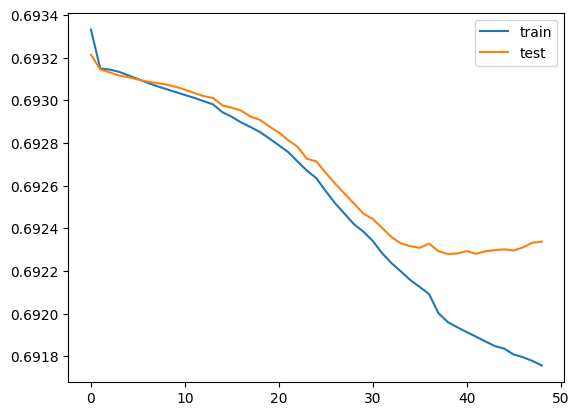

In [61]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [62]:
# adapted from https://stackoverflow.com/a/58598737
# given that the end goal is win probability over time and not predicting the victor,
# this is not a fair measure of the model
# especially difficult with overtime

from sklearn.metrics import confusion_matrix
from numpy import round

predictions = model.predict(X_test)
y_pred = round(predictions)

cm = confusion_matrix(y_test, y_pred)

total = sum(sum(cm))
accuracy = (cm[0,0]+cm[1,1])/total
print ('Accuracy : %.6f' % accuracy)

sensitivity = cm[0,0]/(cm[0,0]+cm[0,1])
print('Sensitivity : %.6f' % sensitivity )

specificity = cm[1,1]/(cm[1,0]+cm[1,1])
print('Specificity : %.6f' % specificity)

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Accuracy : 0.518332
Sensitivity : 0.583333
Specificity : 0.453254


In [63]:
model.save("models/meter_ply_ot_lstm16.keras")